# Imputation experiments

Based on the paper [Comparison of different Methods for Univariate Time Series Imputation in R](https://www.researchgate.net/publication/282906368_Comparison_of_different_Methods_for_Univariate_Time_Series_Imputation_in_R) by Moritz, et al.

## 0 Setup

In [155]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load("forecast", "TSA", "VIM", "zoo")

library(forecast)
library(TSA)
library(VIM)
library(zoo)

## 1 Exploratory data analysis

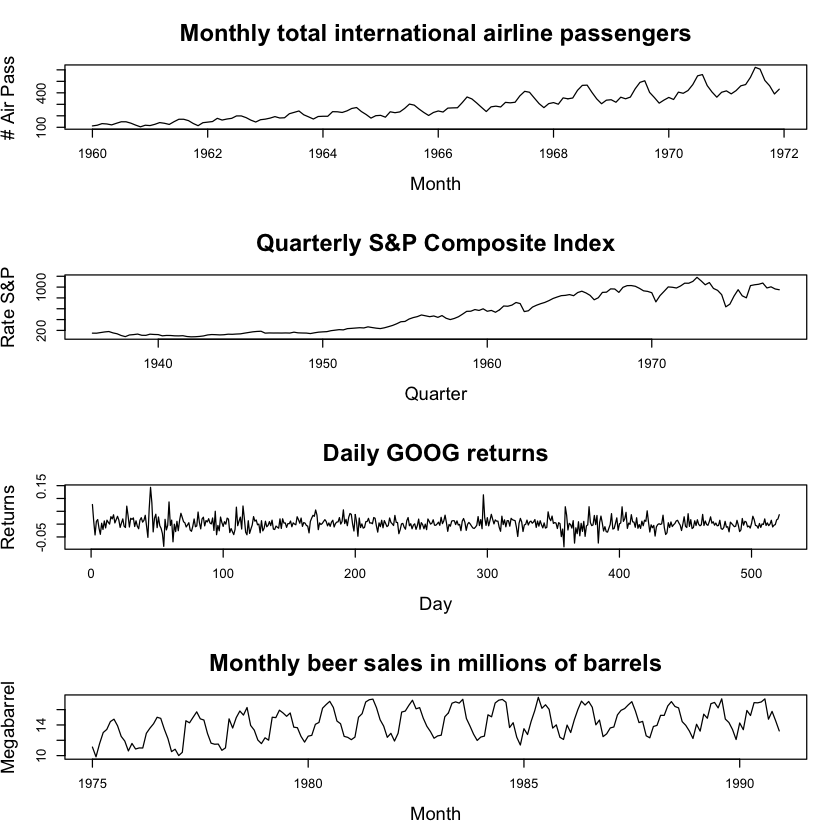

In [2]:
data(list = c("airpass", "SP", "google", "beersales"))
par(mfrow = c(4, 1), cex.main = 1.8, cex.lab = 1.4)
plot(airpass, main = "Monthly total international airline passengers", xlab = "Month", ylab = "# Air Pass")
plot(SP, main = "Quarterly S&P Composite Index", xlab = "Quarter", ylab = "Rate S&P")
plot(google, main = "Daily GOOG returns", xlab = "Day", ylab = "Returns")
plot(beersales, main = "Monthly beer sales in millions of barrels", xlab = "Month", ylab = "Megabarrel")

| Dataset | Trend? | Seasonality? |
| ------- | ------ | ------------ |
| airpass | Yes | Yes |
| SP | Yes | No |
| google | No | No |
| beer | No | Yes |


### 1.1 Decomposition

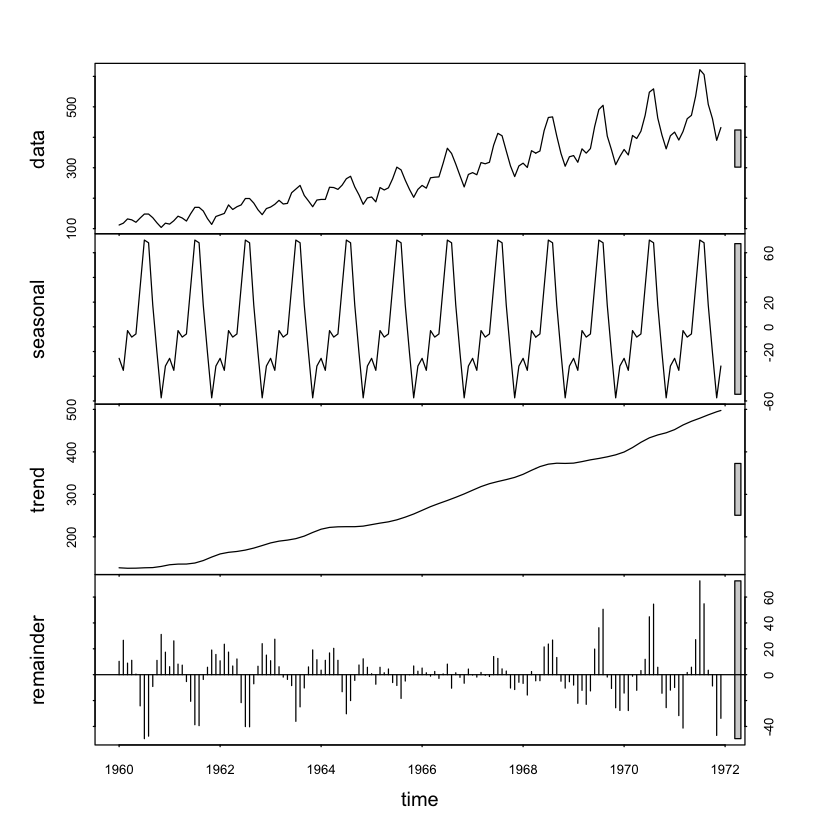

In [3]:
# airpass STL
airpass.stl <- stl(airpass, s.window = "periodic")
plot(airpass.stl)

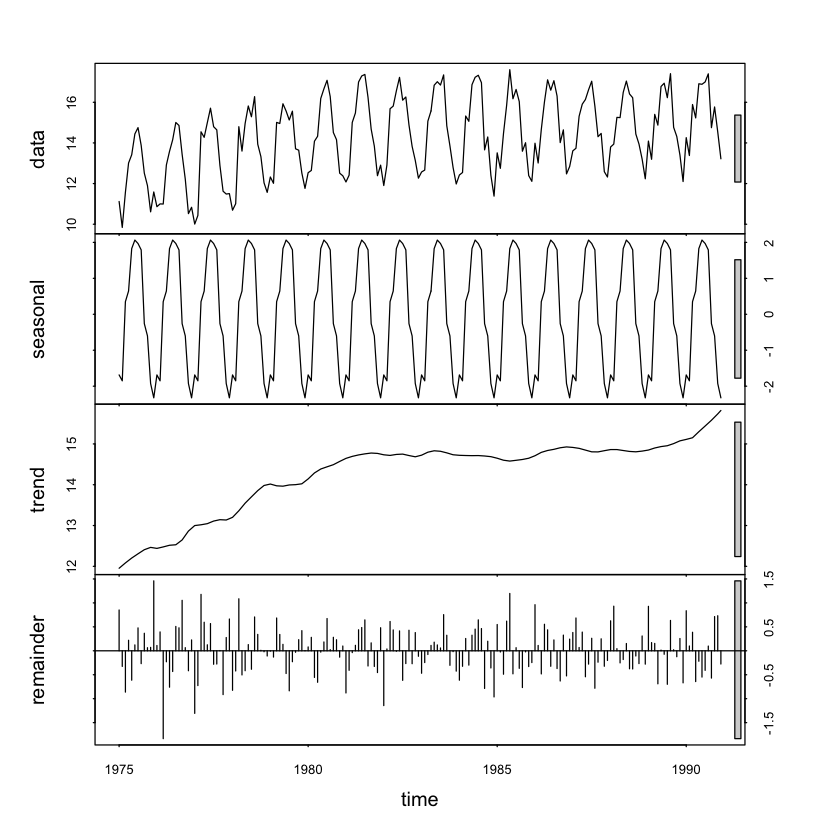

In [4]:
# beersales STL
beersales.stl <- stl(beersales, s.window = "periodic")
plot(beersales.stl)

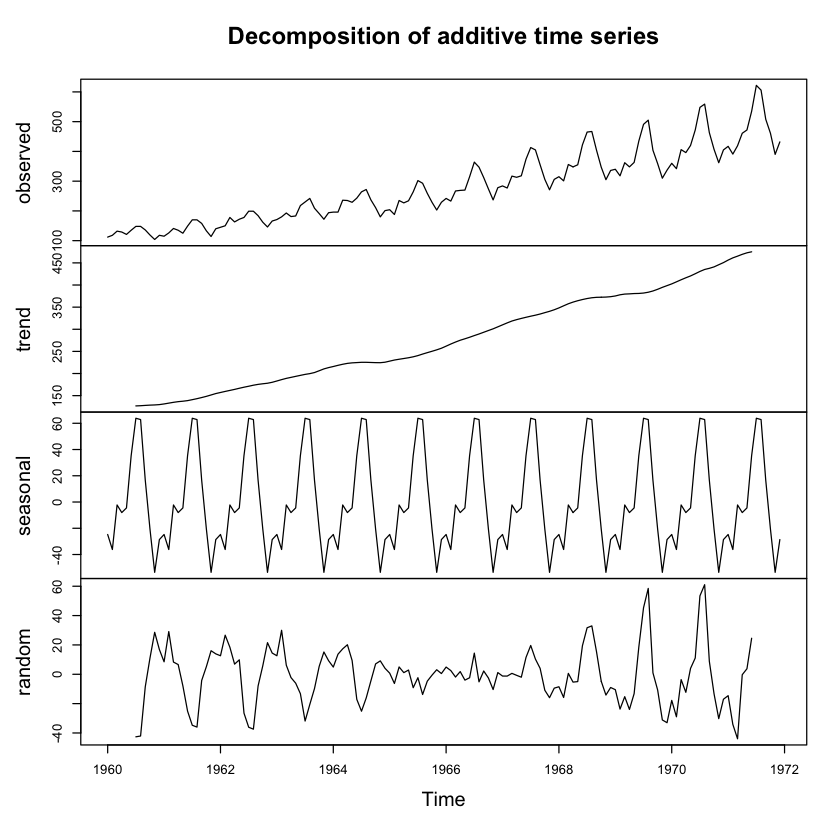

In [5]:
# airpass seasonal moving averages decomposition
airpass.ma <- decompose(airpass)
plot(airpass.ma)

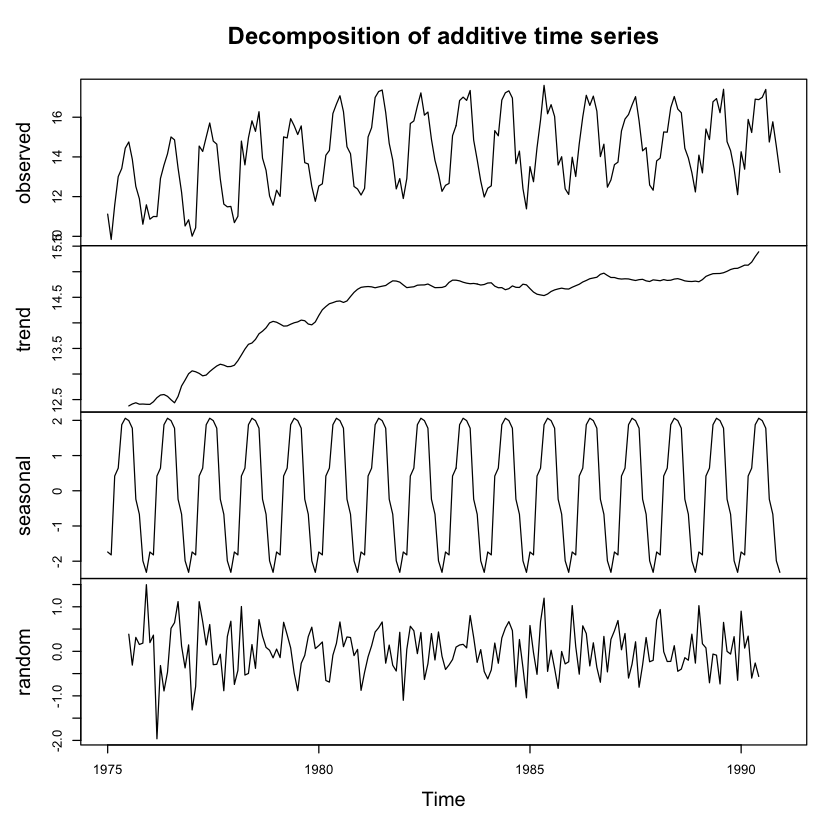

In [6]:
# beersales seasonal moving averages decomposition
beersales.ma <- decompose(beersales)
plot(beersales.ma)

### 1.2 Autocorrelation

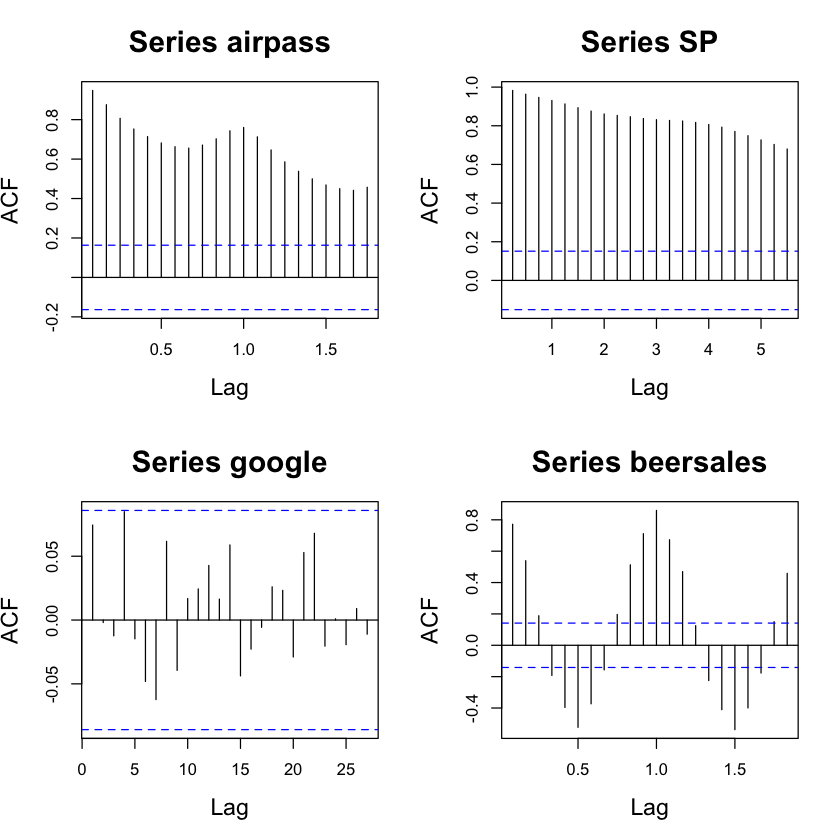

In [7]:
# No plot function call, because it is already called within acf
par(mfrow = c(2, 2), cex.main = 1.8, cex.lab = 1.4)
acf(airpass)
acf(SP)
acf(google)
acf(beersales)

## 2 Simulate missing data

In [8]:
# Missing data simulation
# @param data - univariate time series
# @param rate - lambda value for exponential distribution
# @param seed - random seed
create.missing <- function(data, rate, seed = NULL) {
    
    if (class(data) != "ts") {
        stop("data must be a time series")
    }
    
    if (rate == 0) {
        return(data)
    }
    
    if (!is.null(seed)) {
        set.seed(seed)
    }
    
    t <- time(data)
    f <- frequency(data)
    a <- 0
    temp.delete <- numeric(0)
    
    while (a < length(data)) {
        
        # ceiling to avoid possible zeros
        a <- ceiling(a + rexp(1, rate))
        
        if (a < length(data)) {
            data[a] <- NA
            temp.delete <- c(temp.delete, a)
        }
    }
    
    return(list(data = data, na.ind = temp.delete))
}

## 3 Univariate time series imputation

In [55]:
times <- as.numeric(time(airpass))
na.times <- c(times[10], times[13], times[15])
na.values.orig <- c(airpass[10], airpass[13], airpass[15])

### 3.1 Custom imputation via auto.arima and Kalman filter

In [151]:
data.custom <- airpass
data.custom[c(10, 13, 15)] <- NA

fit <- auto.arima(data.custom)
kal <- KalmanRun(data.custom, fit$model)

tmp <- which(fit$model$Z == 1)
id <- ifelse(length(tmp) == 1, tmp[1], tmp[2])

# Fill in the values
id.na <- which(is.na(data.custom))
data.custom[id.na] <- kal$states[id.na, id]

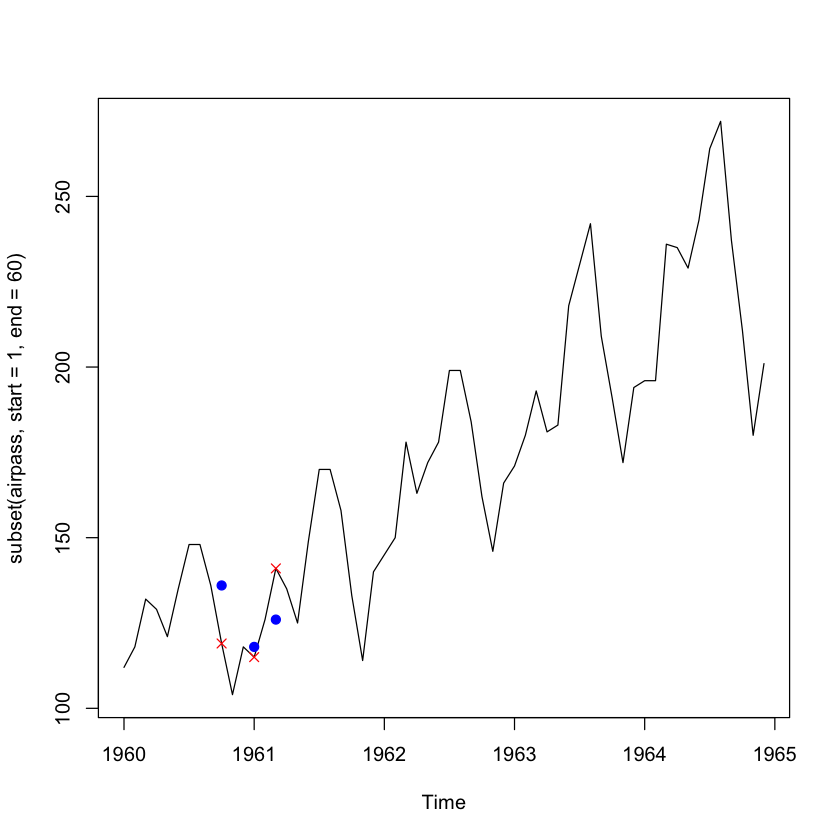

In [140]:
plot(subset(airpass, start=1, end=60))
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.custom[10], data.custom[13], data.custom[15]), pch=19, col="blue")

### 3.2 na.aggregate (zoo)

In [134]:
data <- airpass
data[c(10, 13, 15)] <- NA
data.agg <- na.aggregate(data)

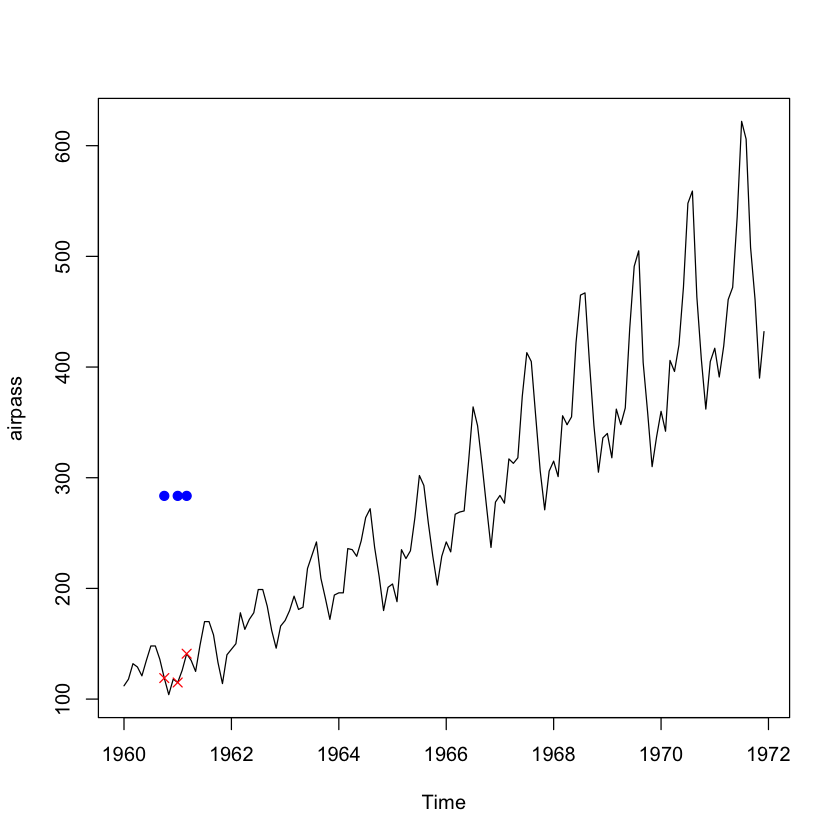

In [135]:
plot(airpass)
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.agg[10], data.agg[13], data.agg[15]), pch=19, col="blue")

### 3.3 na.locf (zoo)

In [142]:
data <- airpass
data[c(10, 13, 15)] <- NA
data.locf <- na.locf(data)

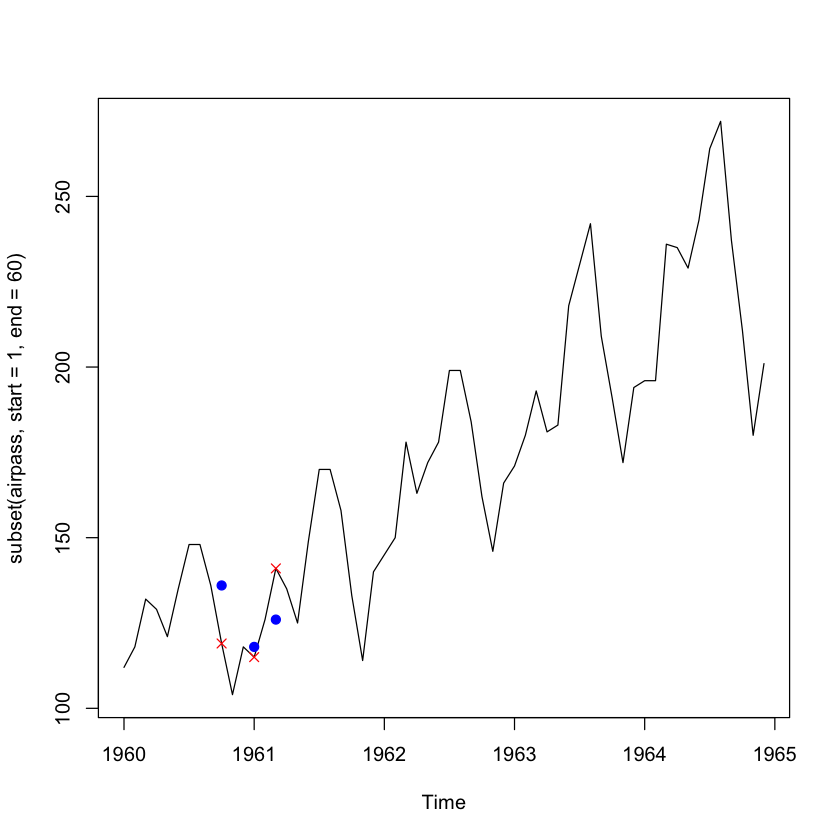

In [143]:
plot(subset(airpass, start=1, end=60))
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.locf[10], data.locf[13], data.locf[15]), pch=19, col="blue")

### 3.4 na.StructTS (zoo)

In [144]:
data <- airpass
data[c(10, 13, 15)] <- NA
data.struct <- na.StructTS(data)

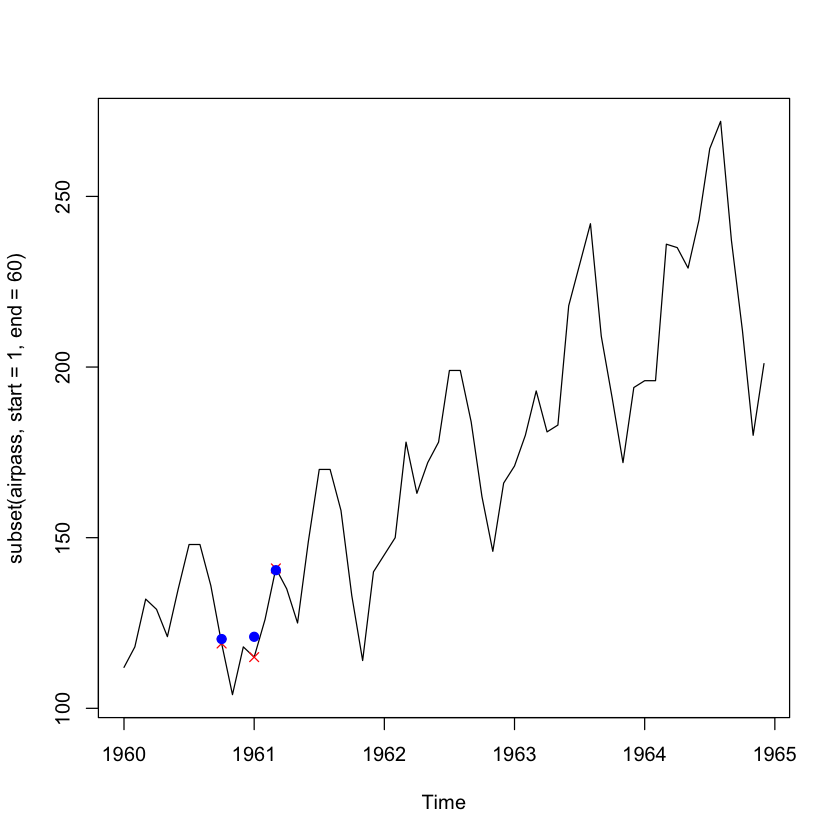

In [145]:
plot(subset(airpass, start=1, end=60))
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.struct[10], data.struct[13], data.struct[15]), pch=19, col="blue")

### 3.5 na.interp (forecast)

In [146]:
data <- airpass
data[c(10, 13, 15)] <- NA
data.interp <- na.interp(data)

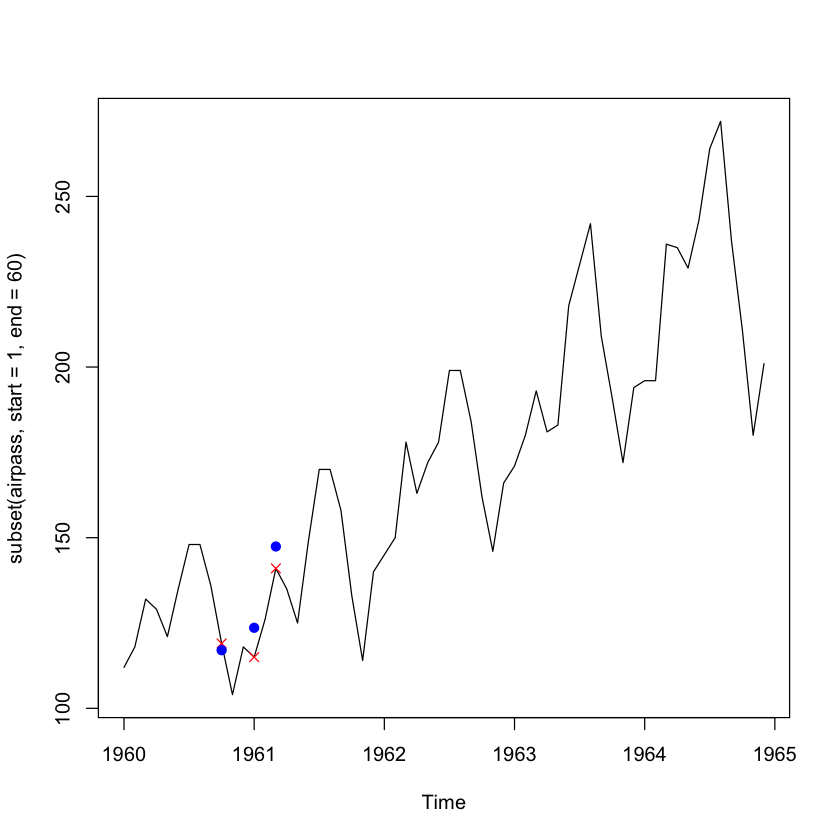

In [147]:
plot(subset(airpass, start=1, end=60))
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.interp[10], data.interp[13], data.interp[15]), pch=19, col="blue")

### 3.6 na.approx (zoo)

In [148]:
data <- airpass
data[c(10, 13, 15)] <- NA
data.approx <- na.approx(data, rule = 2)

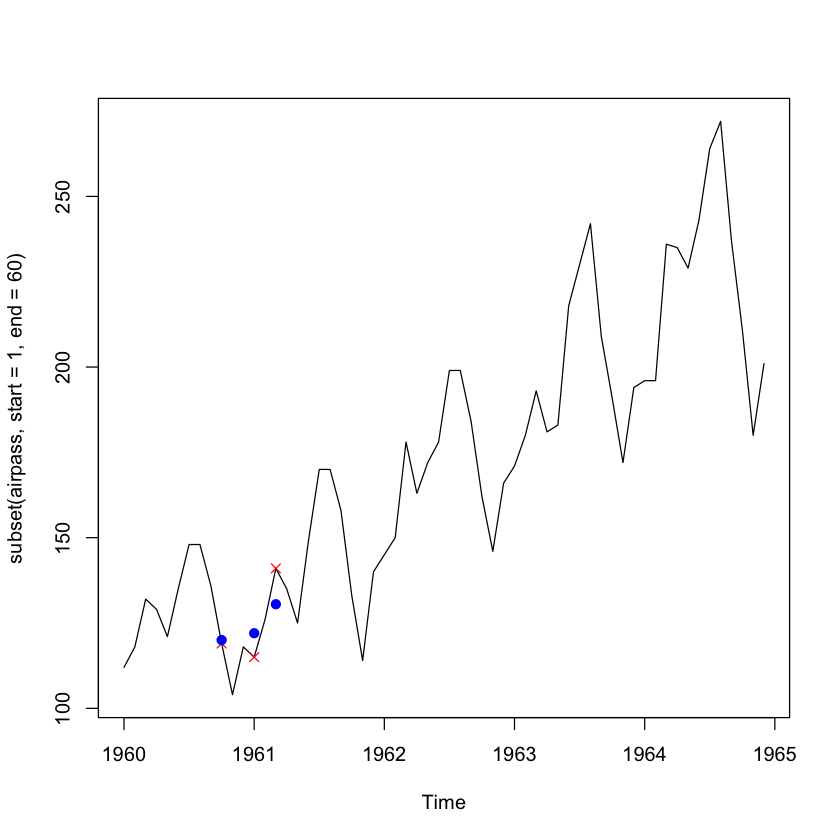

In [149]:
plot(subset(airpass, start=1, end=60))
points(na.times, c(airpass[10], airpass[13], airpass[15]), pch=4, col="red")
points(na.times, c(data.approx[10], data.approx[13], data.approx[15]), pch=19, col="blue")

### 3.7 irmi (VIM + own)

In [160]:
data <- airpass
data[c(10, 13, 15)] <- NA
# Hm, this isn't working
#data.irmi <- irmi(data)